<a href="https://colab.research.google.com/github/StratosFair/DNN_Classifiers_Fast_Rates/blob/main/fashion_mnist_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
import numpy as np

In [18]:
# Load Fashion-MNIST dataset
fashion_transform = transforms.Compose([transforms.ToTensor()])
fashion_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=fashion_transform)
fashion_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=fashion_transform)

# Filter for T-shirt (class 0) and Pullover (class 2)
indices_tshirt_train = [i for i, (img, label) in enumerate(fashion_train) if label == 0]
indices_pullover_train = [i for i, (img, label) in enumerate(fashion_train) if label == 2]
indices_tshirt_test = [i for i, (img, label) in enumerate(fashion_test) if label == 0]
indices_pullover_test = [i for i, (img, label) in enumerate(fashion_test) if label == 2]

# Combine the indices
train_indices = indices_tshirt_train + indices_pullover_train
test_indices = indices_tshirt_test + indices_pullover_test

# Create subsets
train_data = Subset(fashion_train, train_indices)
test_data = Subset(fashion_test, test_indices)

# Binarize labels: T-shirt -> 0, Pullover -> 1
def binarize_labels(subset):
    images, labels = zip(*[(data[0], 1 if data[1] == 2 else 0) for data in subset])
    return torch.stack(images), torch.tensor(labels)

# Binarize train and test labels
X_train, y_train = binarize_labels(train_data)
X_test, y_test = binarize_labels(test_data)

# Verify shapes
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: torch.Size([12000, 1, 28, 28]), Train labels shape: torch.Size([12000])
Test data shape: torch.Size([2000, 1, 28, 28]), Test labels shape: torch.Size([2000])


In [19]:
class DeepReLUNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128):
        super(DeepReLUNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),  # Flatten 28x28 images into 1D
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),  # Output layer (binary classification)
            nn.Sigmoid()  # To output probabilities
        )

    def forward(self, x):
        return self.network(x)

In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = DeepReLUNetwork()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/50, Loss: 0.1536
Epoch 2/50, Loss: 0.1039
Epoch 3/50, Loss: 0.0890
Epoch 4/50, Loss: 0.0859
Epoch 5/50, Loss: 0.0824
Epoch 6/50, Loss: 0.0787
Epoch 7/50, Loss: 0.0728
Epoch 8/50, Loss: 0.0691
Epoch 9/50, Loss: 0.0663
Epoch 10/50, Loss: 0.0623
Epoch 11/50, Loss: 0.0599
Epoch 12/50, Loss: 0.0590
Epoch 13/50, Loss: 0.0536
Epoch 14/50, Loss: 0.0543
Epoch 15/50, Loss: 0.0514
Epoch 16/50, Loss: 0.0490
Epoch 17/50, Loss: 0.0499
Epoch 18/50, Loss: 0.0437
Epoch 19/50, Loss: 0.0439
Epoch 20/50, Loss: 0.0436
Epoch 21/50, Loss: 0.0421
Epoch 22/50, Loss: 0.0385
Epoch 23/50, Loss: 0.0337
Epoch 24/50, Loss: 0.0336
Epoch 25/50, Loss: 0.0365
Epoch 26/50, Loss: 0.0330
Epoch 27/50, Loss: 0.0302
Epoch 28/50, Loss: 0.0297
Epoch 29/50, Loss: 0.0296
Epoch 30/50, Loss: 0.0290
Epoch 31/50, Loss: 0.0297
Epoch 32/50, Loss: 0.0252
Epoch 33/50, Loss: 0.0264
Epoch 34/50, Loss: 0.0240
Epoch 35/50, Loss: 0.0275
Epoch 36/50, Loss: 0.0230
Epoch 37/50, Loss: 0.0200
Epoch 38/50, Loss: 0.0200
Epoch 39/50, Loss: 0.

In [21]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_probs = []
    for images, _ in test_loader:
        outputs = model(images)
        y_pred_probs.extend(outputs.squeeze().tolist())

# Convert predictions to numpy array for histogram
y_pred_probs = np.array(y_pred_probs)

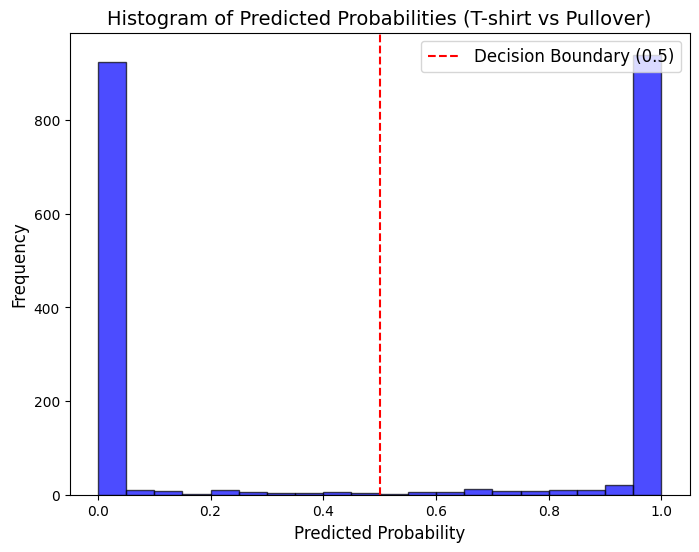

In [22]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(y_pred_probs, bins=20, range=(0, 1), alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Predicted Probabilities (T-shirt vs Pullover)", fontsize=14)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.legend(fontsize=12)
plt.show()